In [1]:
# library definition for using them

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from datetimerange import DateTimeRange
from tqdm import tqdm_notebook as tqdm
import traceback
import demon as d
import mysql.connector

In [3]:
# reading data from cvs dataset in default (data) folder
# discart unused fields "log_start" and "log_and")
# and display first 20 rows

In [4]:
USER=os.getenv('DB_USER')
PWD=os.getenv('DB_USER_PWD')

In [7]:
df = pd.read_csv("data/genera passaggi per python.csv", encoding="latin")
df = df.drop(["log_start","log_end"],axis=1)
df.head(20)

,MAC Address,tempo_log,AP Name,log_startv,log_endv,area
0,00:00:36:75:f5:36,10,Aule-B55-01-PortineriaP1,2018-11-09T15:58:00,2018-11-09T16:08:39,Polo Fibonacci
1,00:00:48:dd:35:b7,606,MED-SC-Ed2-Neonatologia-P1,2018-11-12T05:07:00,2018-11-12T15:13:56,Ospedale Santa Chiara
2,00:00:48:dd:35:b7,1227,MED-SC-Ed2-Neonatologia-P1,2018-11-06T11:40:00,2018-11-07T08:07:54,Ospedale Santa Chiara
3,00:00:6a:4a:28:6a,7,VET-B22-Aula_E,2018-11-07T07:58:00,2018-11-07T08:05:33,Dipartimento di Scienze Veterinarie
4,00:00:b6:ff:50:b6,5,CIS_MED-Ed30C_A_S1-S2_Cor_PT_Est,2018-11-06T10:04:00,2018-11-06T10:09:21,Ospedale di Cisanello
5,00:03:7f:c2:00:43,5,AP_MensaPraticelli,2018-11-06T18:34:00,2018-11-06T18:39:03,Residenza I Praticelli
6,00:03:ab:db:1d:85,5,FARM_AP_Minutolo,2018-11-11T15:57:00,2018-11-11T16:02:22,Dipartimento di Farmacia
7,00:03:ac:19:2e:39,96,ECO_AulaB,2018-11-07T06:30:00,2018-11-07T08:06:00,Dipartimento di Economia
8,00:03:ac:19:2e:39,6,PEA-Aula_L1Ext,2018-11-12T10:56:00,2018-11-12T11:02:23,Dipartimento di Economia
9,00:03:ac:19:2f:c6,10,PalCongressi_RoomE,2018-11-10T12:00:00,2018-11-10T12:10:52,Palazzo Congressi


# Data Understanding

### Capire come sono distribuiti i tempi di connessione.

Posso scartare overlapping non significativi (troppo corti) ?
(dare la definizione di "corti")

Devo considerare il tempo di overlapping in correlazione con il tempo di connesssione?<br>
Oppure i tempi di overlapping sono distribuiti come i tempi di connessione? 

In [8]:
# define functions for calculating time-interval in seconds (intersection and union)

In [9]:
import datetime
def calcolasecondi_intersect (range1,range2):
    inter = range1.intersection(range2)
    estremo1 = str(inter).split(" - ")[0]
    estremo2 = str(inter).split(" - ")[1]
    return ((np.datetime64(estremo2) - np.datetime64(estremo1)) / np.timedelta64(1, 's'))
def calcolasecondi_union (range1,range2):
    inter = range1.encompass(range2)
    estremo1 = str(inter).split(" - ")[0]
    estremo2 = str(inter).split(" - ")[1]
    return ((np.datetime64(estremo2) - np.datetime64(estremo1)) / np.timedelta64(1, 's'))

In [10]:
# set the list of APs we want to examine. To change for DB use 
Uso=["Didattica"]

In [11]:
different_AP = ["VET-B22-Aula_E"] #,"CIS_MED_Ed30C_S1-S2_Corr_PT_Int"]
# Read AP list to analyse from a csv and filter them for "Uso"

#df_AP =  pd.read_csv("data/ElencoAP.csv", encoding="latin")
#df_AP = df_AP.drop(["id","Area","Ethernet MAC Address","IP Address","AP Location"],axis=1)
#different_AP=[]
#for i in (range(0,len(df_AP)-1)):
#    print(df_AP[i])
#    if Uso in df_AP[i] : different_AP.append(df_AP[i])

#for AP in Uso:
#    AP1=df_AP[df_AP["Uso"]==AP].values
#    for i in tqdm(range(0,len(AP1)-1)):
#        different_AP.append(AP1[i][0]) 

In [12]:
# generate the overlapping-time list of the selected APs

In [17]:
# genera lista con tutti i tempi di overlapping di una lista di access point (AP)
# different_AP = [AP] 
# different_AP = set(df["AP Name"])
overlapping_time = []
for AP in tqdm(different_AP):
    df_AP = df[df["AP Name"]==AP].values
    for i in range(0,len(df_AP)-1):
        for j in range(i+1,len(df_AP)):
            try:
                datarange1= DateTimeRange(df_AP[i][3],df_AP[i][4])
                datarange2= DateTimeRange(df_AP[j][3],df_AP[j][4])
                is_inters = datarange1.is_intersection(datarange2)
                if (is_inters):
                    assert(df_AP[i][0] != df_AP[j][0])
                    overlapping_time.append(calcolasecondi_intersect(datarange1,datarange2))
            except ValueError:
                print ("problemi con le date")
                print (df_AP[i][2],df_AP[i][3])
                print (df_AP[j][2],df_AP[j][3])
                traceback.print_exc()
                break


In [18]:
#for x in range(len(overlapping_time)): 
#    print (overlapping_time[x])

In [19]:
# For the specifics APs, it plots:
#  - barchart overlap time (all couples of users)
#  - barchart log time (all single users)
# To compare how diffents are the log-time function from overlapping-time one. 

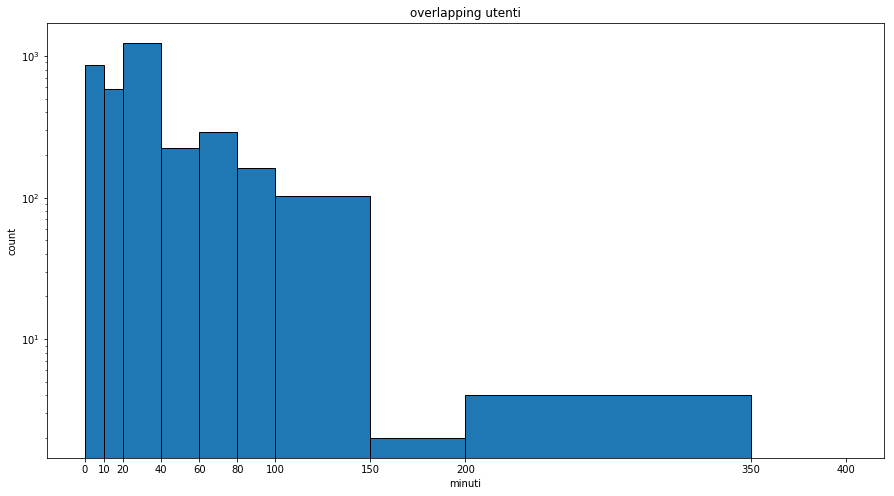

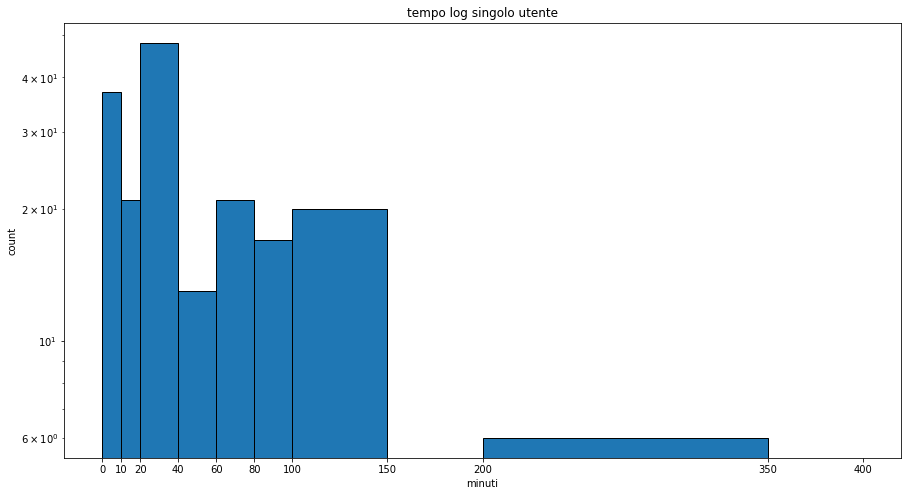

In [20]:
plt.figure(figsize = (15,8))
bins=[0,10,20,40,60,80,100,150,200,350,400]
plt.title("overlapping utenti")
plt.ylabel("count")
plt.xlabel("minuti")
plt.hist(np.array(overlapping_time)/60.0, bins=bins, log=True, ec='black')
plt.xticks(bins)

plt.show()


plt.figure(figsize = (15,8))
plt.title("tempo log singolo utente")
plt.ylabel("count")
plt.xlabel("minuti")
plt.hist(df[df["AP Name"]==AP]["tempo_log"], bins=bins, log=True, ec='black')
plt.xticks(bins)

plt.show()



Corto vuol dire < 20 minuti <br>


# Social Network

###  Rete di prossimità

* nodi: gli utenti
* archi: se due utenti sono stati connessi allo stesso AP contemporaneamente per più di N minuti (N =~ 20, da perfezionare)

In [21]:
#Read Areas to analyse from a csv

df_AREE = pd.read_csv("data/Aree.csv", encoding="latin")
#df_AREE = df_AREE.drop(["id","indirizzo","città","cap","latitudine", "longitudine", "Descrizione", "Macroarea"],axis=1)
selected_area=df_AREE["nome"]

# or fix one or more
#selected_area = ["Dipartimento di Chimica"]

In [ ]:
# per generare la rete la prima volta
# non sempre necessario eseguirla, posso aprire un file con una rete esportata
#selected_area = pd.read_csv("data/selezione.txt", header=None, encoding="latin")

tempoMinimo = 20.0 * 60.0
for area in selected_area:
    archi = {}
    df_area = df[df["area"]==area].values
    for i in tqdm(range(0,len(df_area)-1)):
        for j in range(i+1,len(df_area)):
            try:
                datarange1= DateTimeRange(df_area[i][3],df_area[i][4])
                datarange2= DateTimeRange(df_area[j][3],df_area[j][4])
                is_inters = datarange1.is_intersection(datarange2)
                if (is_inters):
                    assert(df_area[i][0] != df_area[j][0])
                    overlapping = calcolasecondi_intersect(datarange1,datarange2)
                    allperiod = calcolasecondi_union(datarange1,datarange2)
                    if (overlapping >= tempoMinimo):
                        assert(df_area[i][0] != df_area[j][0])
                        coppia = (df_area[i][0],df_area[j][0])
                        if (coppia in archi): archi[coppia] += 1*(overlapping/allperiod)
                        else: archi[coppia] = 1*(overlapping/allperiod)
            except ValueError:
                print ("problemi con le date")
                print (df_area[i][2],df_area[i][3])
                print (df_area[j][2],df_area[j][3])
                traceback.print_exc()
                break
                
archi_graph = []
for elem in archi:
    single_arch = (elem[0],elem[1],{"weight": archi[elem]})
    archi_graph.append(single_arch)
    
archi_graph

In [39]:
G = nx.Graph()
G.add_edges_from(archi_graph)

In [40]:
# G = nx.read_gexf("test.gexf")

print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())

Nodes: 345
Edges: 20919


# DEMON
#### comunities con overlapping

In [41]:
dm = d.Demon(graph=G, epsilon=0.35, min_community_size=3)
coms = dm.execute()

Exec: 100%|████████████████████████

Time:  'execute' 61.64 sec
------------------------------------


In [ ]:
# grandezza delle comunità trovate
I=0
for com in coms:
   I=I+1 
   print("com", I, ":", len(com), "items")

In [43]:
# costruisco dizionario {nodo -> comunità}
coms_dict = {}
for i,com in enumerate(coms):
    for node in com:
        coms_dict[node] = i+1

coms_dict

{'08:3e:8e:c1:fd:db': 5,
 '10:44:00:80:b9:4c': 3,
 '14:10:9f:e8:0e:90': 2,
 '1c:23:2c:5e:6b:99': 3,
 '48:43:7c:3c:9d:a0': 3,
 '48:74:6e:6e:b9:c4': 3,
 '68:14:01:7e:c9:bf': 3,
 '6c:19:c0:1f:6e:6e': 3,
 '6c:71:d9:58:da:73': 3,
 '70:70:0d:50:af:8a': 3,
 '74:de:2b:18:0c:fa': 3,
 '84:4b:f5:12:4b:85': 3,
 '88:63:df:0f:81:ab': 1,
 '88:83:22:e2:a5:e1': 3,
 '8c:1a:bf:ed:6a:ca': 6,
 'b0:35:8d:24:17:28': 3,
 'b0:35:9f:37:40:e7': 3,
 'b8:e8:56:14:c8:f0': 2,
 'f0:03:8c:ca:6f:7b': 3,
 '00:71:cc:6d:8a:06': 2,
 '08:ee:8b:9d:9f:6f': 2,
 '1c:4d:70:7c:0e:48': 2,
 '20:10:7a:2a:4b:b8': 2,
 '2c:0e:3d:52:2b:1b': 2,
 '3c:95:09:9f:e4:df': 3,
 '48:e9:f1:92:17:6c': 2,
 '58:fb:84:82:53:93': 2,
 '5c:f8:a1:91:5a:bc': 2,
 '64:76:ba:98:62:9c': 2,
 '7c:04:d0:cd:85:ae': 2,
 '90:06:28:26:85:99': 3,
 '9c:5c:8e:34:27:2a': 2,
 'a2:53:ce:81:8a:84': 2,
 'a4:34:d9:8d:14:c7': 2,
 'b0:35:9f:18:63:4d': 2,
 'c4:85:08:7d:b0:ef': 2,
 '00:6d:52:30:62:74': 6,
 '00:b3:62:24:68:22': 6,
 '00:cd:fe:d7:22:1f': 6,
 '00:e7:02:38:f5:c2': 6,


/home/roberto/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


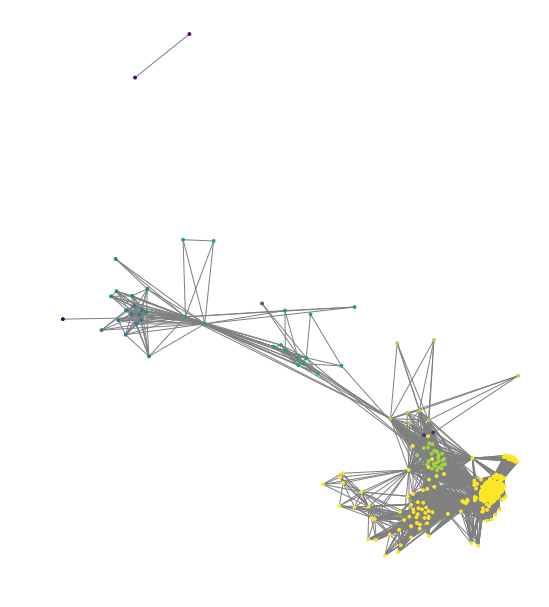

In [22]:
# siccome le comunità sono sovrapposte, pessimo approccio.

color_map = []
for node in G:
    if node in coms_dict: color_map.append(coms_dict[node])
    else: color_map.append(0)

plt.figure(figsize=(7,8))
nx.draw(G, node_size=8, edge_color='grey', node_color=color_map, pos=nx.spring_layout(G))
plt.show()

# Louvain

#### no overlapping

/home/roberto/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


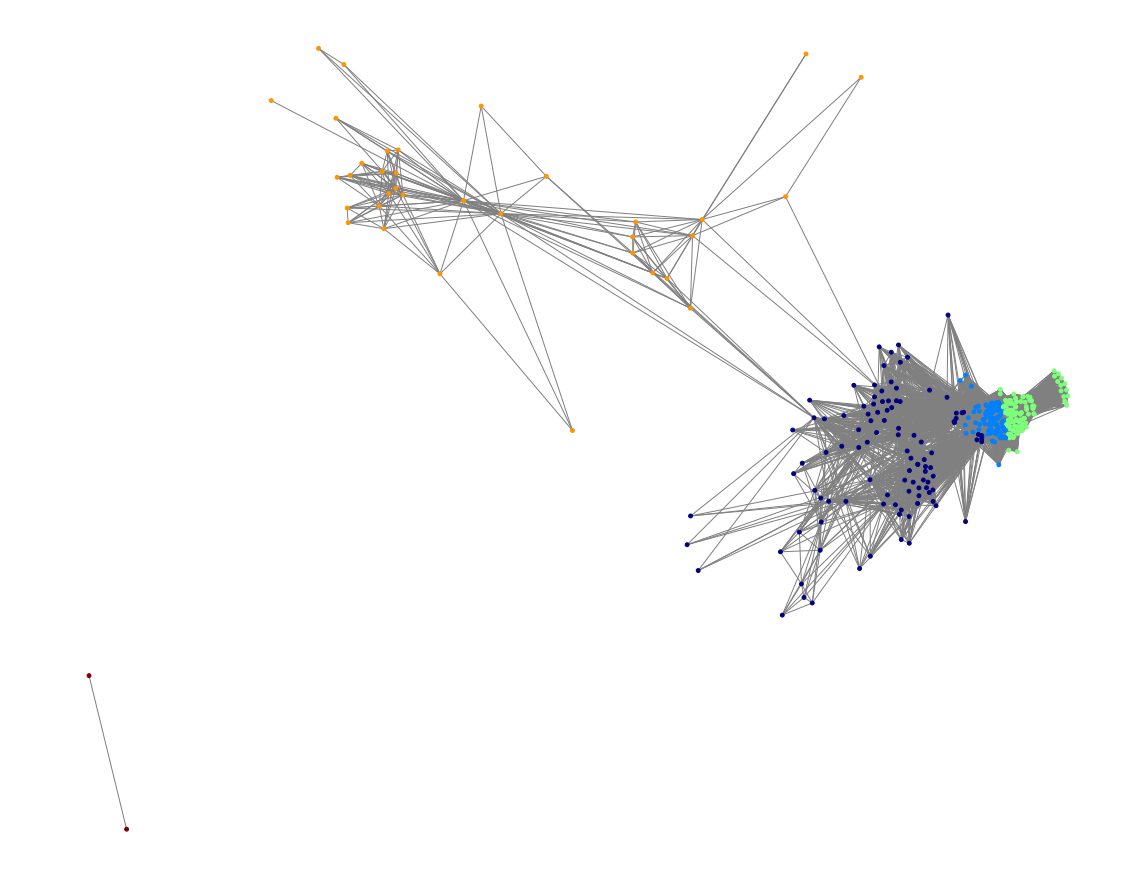

In [24]:
import community.community_louvain as community
part = community.best_partition(G)

values = [part.get(node) for node in G.nodes()]
plt.figure(figsize=(15,12))
nx.draw_spring(G, cmap = plt.get_cmap('jet'), node_color = values, node_size=15, with_labels=False, edge_color='grey')
plt.show()

In [25]:
# statistiche
mod_louvain = community.modularity(part,G)
print("modularity:", mod_louvain)

modularity: 0.18925061442746813
